## Visualization toolbox for torch

A rewrite of CNN visualization example from ["Lasagne"](https://github.com/Lasagne/Recipes/blob/master/examples/Saliency%20Maps%20and%20Guided%20Backpropagation.ipynb) and ["PyTorch"](https://github.com/leelabcnbc/cnnvis-pytorch/blob/master/test.ipynb) in torch.

They did exactly the same thing. However, the results are not exactly the same. 

### Requirements
- Install Torch with CUDA GPU. Install the basic packages (nn, optim, image, cutorch, cunn).
- [cudnn](https://developer.nvidia.com/cudnn) and [torch bindings](https://github.com/soumith/cudnn.torch).
- [loadcaffe](https://github.com/szagoruyko/loadcaffe)

In [1]:
require 'nn'
require 'cunn'
require 'cutorch'
require 'cudnn'
require 'loadcaffe'
require 'image'
require 'gnuplot'
require 'sys'
-- download VGG-16 model
if not paths.filep('VGG_ILSVRC_16_layers.caffemodel') then
    sys.execute('wget http://www.robots.ox.ac.uk/~vgg/software/very_deep/caffe/VGG_ILSVRC_16_layers.caffemodel')
    sys.execute('wget https://gist.githubusercontent.com/ksimonyan/211839e770f7b538e2d8/raw/0067c9b32f60362c74f4c445a080beed06b07eb3/VGG_ILSVRC_16_layers_deploy.prototxt')
end
-- load model
model = loadcaffe.load('VGG_ILSVRC_16_layers_deploy.prototxt',
    'VGG_ILSVRC_16_layers.caffemodel','cudnn')
-- remove the softmax function
model:remove(40)
model:add(nn.Max(2))
model:evaluate()
if not paths.filep('4334173592_145856d89b.jpg') then
    sys.execute('wget http://farm5.static.flickr.com/4064/4334173592_145856d89b.jpg')
end

Successfully loaded VGG_ILSVRC_16_layers.caffemodel


conv1_1: 64 3 3 3
conv1_2: 64 64 3 3
conv2_1: 128 64 3 3


conv2_2: 128 128 3 3
conv3_1: 256 128 3 3
conv3_2: 256 256 3 3


conv3_3: 256 256 3 3


conv4_1: 512 256 3 3


conv4_2: 512 512 3 3


conv4_3: 512 512 3 3


conv5_1: 512 512 3 3


conv5_2: 512 512 3 3


conv5_3: 512 512 3 3


fc6: 1 1 25088 4096


fc7: 1 1 4096 4096


fc8: 1 1 4096 1000


In [2]:
-- preprocess input image
function prepareImage(img)
    local perm = torch.LongTensor{3,2,1}
    local mean = torch.Tensor({103.939, 116.779, 123.68})
    --resize
    local w, h = img:size(3), img:size(2)
    if h<w then
        img = image.scale(img,w*256/h,256)
    else
        img = image.scale(img,256,h*256/w)
    end
    -- center crop
    local h1 = math.ceil((img:size(2)-224)/2)
    local w1 = math.ceil((img:size(3)-224)/2)
    local w, h = img:size(3), img:size(2)
    --img = image.crop(img,w1,h1,w1+224,h1+224)
    img = image.crop(img,math.ceil(w/2)-112,math.ceil(h/2)-112,
        math.ceil(w/2)+112,math.ceil(h/2)+112)
    ori_img = img:clone()
    -- transpose, normalize
    img = img:index(1,perm)

    mean = mean:view(3,1,1):expandAs(img):div(255)
    img = img:add(-1,mean)--img - mean
    return ori_img, img
end 
-- plot image
function showImage(ori_img,saliency,max_class, title)
    saliency = saliency:squeeze():float()
    max_img = torch.abs(saliency):max(1):expandAs(ori_img)/torch.max(saliency)
    pos_img = torch.cmax(grad,0)/torch.max(saliency)
    neg_img = torch.cmax(-grad,0)/-torch.min(saliency)
    formatted = image.toDisplayTensor({input={ori_img,max_img,pos_img,neg_img},
        nrow=2,padding=25})
    formatted:float()
    formatted = image.drawText(formatted, "Input",100,0,{color={0,0,0},size=2})
    formatted = image.drawText(formatted, "Abs",340,0,{color={0,0,0},size=2})
    formatted = image.drawText(formatted, "Pos",100,240,{color={0,0,0},size=2})
    formatted = image.drawText(formatted, "Neg",340,240,{color={0,0,0},size=2})

    itorch.image(formatted)
    return ori_img
    
end
-- wrapper to get the saliency
function getSaliency(model, img)
    pred = model:forward(img)
    dummy_label = pred:clone():fill(1)
    grad = model:backward(img,dummy_label)
    model:zeroGradParameters()
    return grad
end

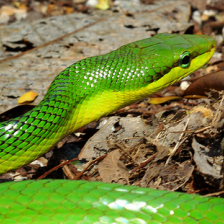

In [3]:
-- load image
img = image.load('4334173592_145856d89b.jpg',3,'double')
ori_img, img = prepareImage(img)
itorch.image(ori_img)

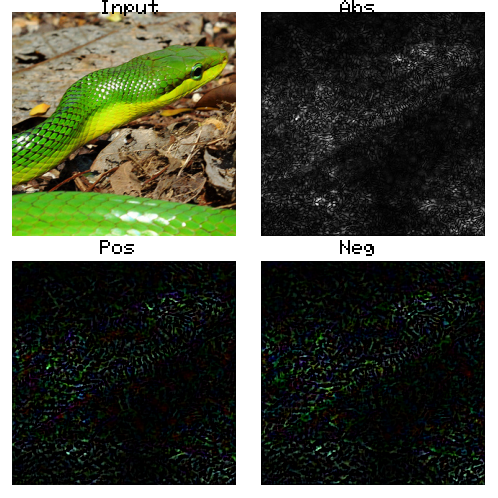

In [4]:
-- Simonyan et al. (2013): Plain Gradient
model1=model:clone('weight','bias');
model1:cuda()
input = img:resize(1,3,224,224):cuda()
grad = getSaliency(model1, input)
-- output index
--_, max_output = torch.max(model.modules[39].output,2)
showImage(ori_img,grad)

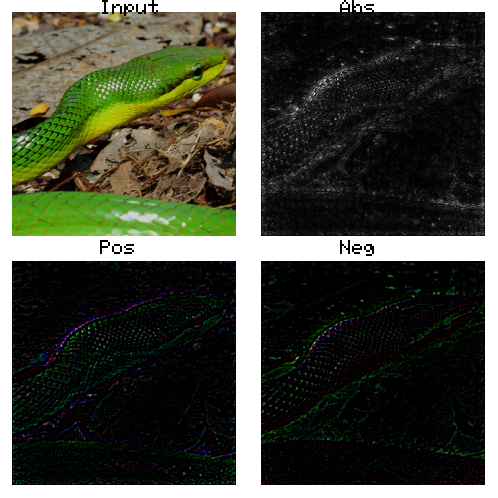

In [5]:
-- Springenberg et al. (2015): Guided Backpropagation
dofile('modified_ReLU.lua')
model2=model:clone('weight','bias');
model2:replace(function(module)
    if torch.typename(module) == 'cudnn.ReLU' then
        return nn.ModifiedReLU()
    else
        return module
    end
end)
model2:cuda()
input = img:resize(1,3,224,224):cuda()
grad = getSaliency(model2, input)
showImage(ori_img,grad)

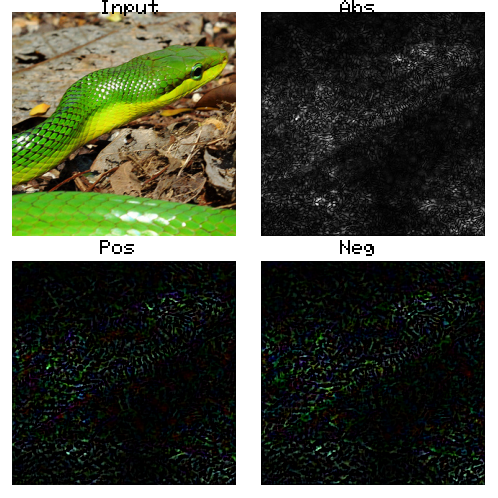

In [6]:
-- Zeiler et al. (2013): DeconvNet
dofile('guided_ReLU.lua')
model3=model:clone('weight','bias');
model3:remove(40)
model3:add(nn.Max(2))
model3:replace(function(module)
    if torch.typename(module) == 'nn.ModifiedReLU' then
        return nn.GuidedReLU()
    else
        return module
    end
end)
model3:cuda()
input = img:resize(1,3,224,224):cuda()
grad = getSaliency(model3, input)
showImage(ori_img,grad)

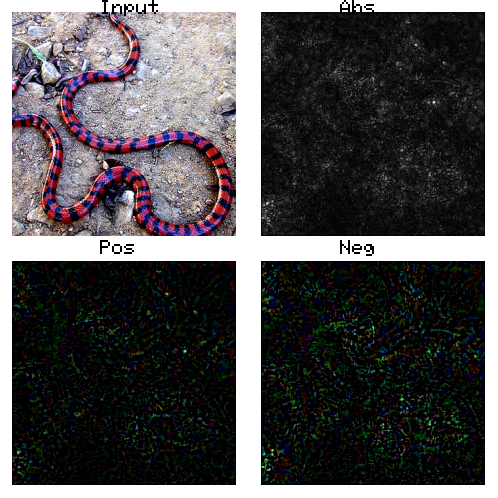

In [7]:
-- More examples
if not paths.filep('5595774449_b3f85b36ec.jpg') then
    sys.execute('wget http://farm6.static.flickr.com/5066/5595774449_b3f85b36ec.jpg')
end
img = image.load('5595774449_b3f85b36ec.jpg')
ori_img, img = prepareImage(img)
input = img:resize(1,3,224,224):cuda()
grad = getSaliency(model1, input)
showImage(ori_img,grad)

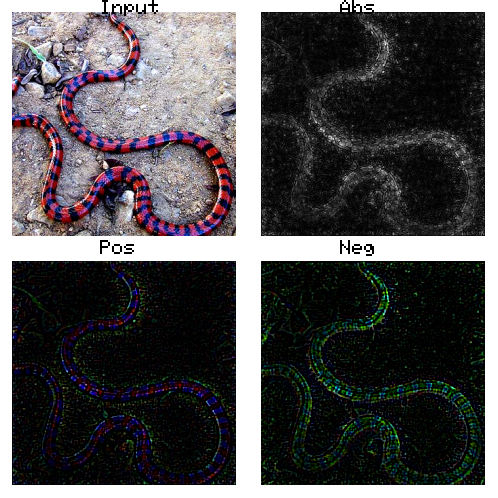

In [8]:
grad = getSaliency(model2, input)
showImage(ori_img,grad)

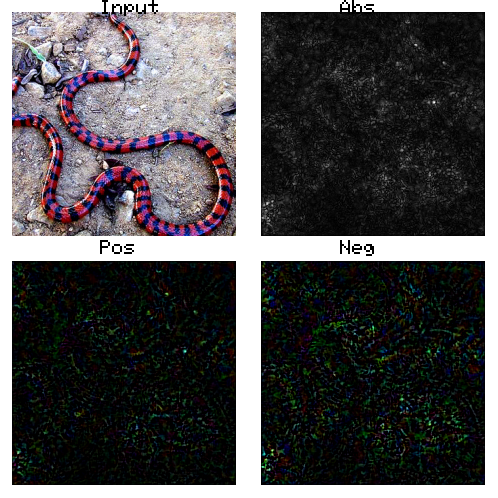

In [9]:
grad = getSaliency(model3, input)
showImage(ori_img,grad)